# 1d mnist classification with a heterogenous MLP model

### env management

In [47]:
%env "WANDB_NOTEBOOK_NAME" "hetero_1dmnist_no_strat.ipynb"
%env WANDB_SILENT=True
%load_ext autoreload
%reload_ext autoreload
# %env XLA_PYTHON_CLIENT_MEM_FRACTION=0.3

env: "WANDB_NOTEBOOK_NAME"="hetero_1dmnist_no_strat.ipynb"
env: WANDB_SILENT=True
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### imports and setup

In [48]:
import jax
import numpy as np
import jax.numpy as jnp
import equinox as eqx
import optax
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import Normalize
import matplotlib.style as mplstyle
import seaborn as sns

from NeuralNetworkEvolution.config import MLPConfig
from NeuralNetworkEvolution.activations import sin
from NeuralNetworkEvolution.mlp import CustomMLP, mlp_plot

from mnist1d.data import make_dataset, get_dataset_args, get_templates

import os
import sys
import time
import logging
import wandb

In [49]:
plt.style.use('default')
sns.set_theme(context='paper', style='white', palette='vlag', font='serif',
            font_scale=2, color_codes=True, rc={'text.usetex' : True})
# mplstyle.use('fast')

In [50]:
class MidpointNormalize(Normalize):
    """
    Normalize and shift the colormap to center 0
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        (vmin, vmax, midpoint) = self.vmin, self.vmax, self.midpoint
        if vmin is None or vmax is None:
            vmin, vmax = np.min(value), np.max(value)
        if midpoint is None:
            midpoint = (vmin + vmax) / 2
        result = np.ma.masked_array(np.interp(value, [vmin, midpoint, vmax], [0, 0.5, 1]))
        if is_scalar:
            result = np.atleast_1d(result)[0]
        return result

In [51]:
def plot_1dmnist(xs, t, labels=None, ratio=2.6, dark_mode=False, zoom=1):
    rows, cols = 1, 10
    fig = plt.figure(figsize=[cols*1.5,rows*1.5*ratio], dpi=60)
    for r in range(rows):
        for c in range(cols):
            ix = r*cols + c
            x, t = xs[ix], t
            ax = plt.subplot(rows,cols,ix+1)

            if dark_mode:
                plt.plot(x, t, 'wo', linewidth=6)
                ax.set_facecolor('k')
            else:
                plt.plot(x, t, 'k-', linewidth=2)
            if labels is not None:
                plt.title("label=" + str(labels[ix]), fontsize=22)

            plt.xlim(-zoom,zoom) ; plt.ylim(-zoom,zoom)
            plt.gca().invert_yaxis() ; plt.xticks([], []), plt.yticks([], [])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout() ; plt.show()
    return fig

### config

In [52]:
jax.config.update('jax_platform_name', 'cpu')

In [53]:
input_size = 40
hidden_sizes = [32, 32]
output_size = 10
min_neurons = 64 + output_size

initial_activation_list = [jax.nn.relu, jax.nn.tanh, sin]
activation_list = [jax.nn.relu, jax.nn.tanh, sin]
optimizer = optax.adabelief
bias = False
num_epochs = 3000
intervene_every = 100
seed = 0
key = jax.random.PRNGKey(seed)
threshold = 1e-4
grad_norm_threshold = 1e-3
n_samples = 20000
test_size = 0.2
learning_rate = 3e-4

act_string = "_".join([act.__name__ for act in initial_activation_list])

config = MLPConfig(input_size=input_size,
                output_size=output_size,
                hidden_sizes=hidden_sizes,
                initial_activation_list=initial_activation_list,
                seed=seed)

In [54]:
config.__dict__.update({'n_samples': n_samples,
                        'learning_rate': learning_rate,
                        'num_epochs': num_epochs,
                        'intervene_every': intervene_every,
                        'threshold': threshold,
                        'activation_list': activation_list})

In [55]:
# jax.config.update("jax_enable_x64", True)

Description = f"Hetero_{act_string}_1dmnist_no_strat_{optimizer.__name__}_no_bias_min_{min_neurons}_{hidden_sizes[0]}_{hidden_sizes[1]}_{num_epochs}_{intervene_every}_{threshold}_{seed}"
fig_folder = f"../figures/{Description}"
out_folder = f"../output/{Description}"
os.makedirs(fig_folder, exist_ok=True)
os.makedirs(out_folder, exist_ok=True)

### logging

In [56]:
print(f"# devices: {jax.local_device_count()}")

logging.basicConfig(level=logging.INFO, filename=f"{out_folder}/info.log", filemode="w")
console = logging.StreamHandler(sys.stdout)
console.setLevel(logging.INFO)
logging.getLogger("").addHandler(console)
logging.info(f"Description: {Description}")
logging.info(f"jax backend: {jax.lib.xla_bridge.get_backend().platform}")
logging.info(f"jax devices: {jax.devices()}")

# devices: 1
Description: Hetero_relu_tanh_sin_1dmnist_no_strat_adabelief_no_bias_min_74_32_32_3000_100_0.0001_0
Description: Hetero_relu_tanh_sin_1dmnist_no_strat_adabelief_no_bias_min_74_32_32_3000_100_0.0001_0
jax backend: cpu
jax backend: cpu
jax devices: [CpuDevice(id=0)]
jax devices: [CpuDevice(id=0)]


In [57]:
run = wandb.init(project="neural-network-evolution", name=Description, config=config.__dict__)


### data

In [58]:
data_config = get_dataset_args()

In [59]:
data_config.num_samples = n_samples
data_config.shuffle_seq = True

In [60]:
data = make_dataset(data_config)

In [61]:
x_train, y_train = data["x"], data["y"]
x_test, y_test = data["x_test"], data["y_test"]
template = data["t"]

In [62]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, template.shape

((16000, 40), (16000,), (4000, 40), (4000,), (40,))

(array([1613., 1598., 1597., 1614., 1571., 1589., 1597., 1602., 1600.,
        1619.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

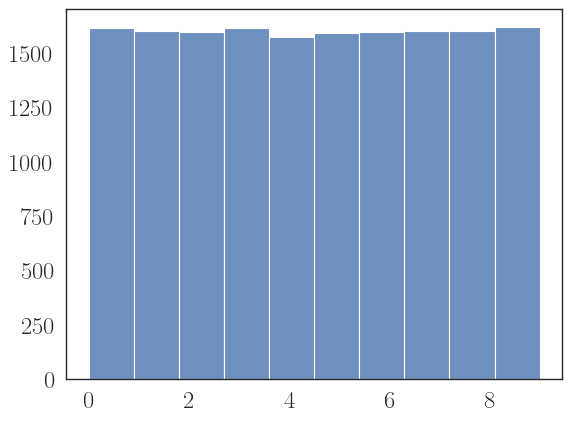

In [63]:
plt.hist(y_train)

Templates for the MNIST-1D dataset:


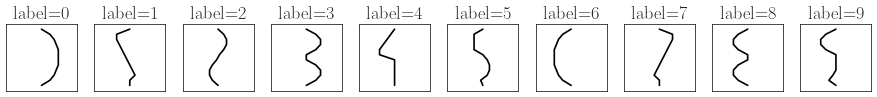

<Figure size 640x480 with 0 Axes>

In [64]:
templates = get_templates()
print("Templates for the MNIST-1D dataset:")
x = templates['x']
t = templates['t']
y = templates['y']
fig = plot_1dmnist(x, t, labels=y, ratio=1.33, dark_mode=False)
plt.savefig(f"{fig_folder}/mnist1d_templates.pdf", bbox_inches='tight')
plt.savefig(f"{fig_folder}/mnist1d_templates.svg", bbox_inches='tight', format='svg')


### training and eval scheme

In [65]:
def initialize_optimizer_state(mlp, optimizer):
    """
    Optimizer initialization that filters for float arrays in the jax pytrees
    """
    return optimizer.init(eqx.filter(mlp, eqx.is_inexact_array))

In [66]:
@jax.jit
def cross_entropy(y, pred_y):
    # y are the true targets, and should be integers 0-9.
    # pred_y are the log-softmax'd predictions.
    pred_y = jnp.take_along_axis(pred_y, jnp.expand_dims(y, 1), axis=1)
    return -jnp.mean(pred_y)

In [67]:
@eqx.filter_value_and_grad()
def compute_loss(mlp, x, y):
    pred_y = jax.nn.log_softmax(jax.vmap(mlp)(x))
    loss = cross_entropy(y, pred_y)
    return loss

In [68]:
@eqx.filter_jit()
def accuracy(mlp, x, y):
    logits = jax.vmap(mlp)(x)
    return jnp.mean(jnp.argmax(logits, axis=-1) == y)

In [69]:
@eqx.filter_jit()
def train_step(mlp, x, y, opt_state, opt_update):
    loss, grads = compute_loss(mlp, x, y)
    updates, opt_state = opt_update(grads, opt_state)
    mlp = eqx.apply_updates(mlp, updates)
    return loss, mlp, opt_state

In [70]:
@eqx.filter_jit()
def test_step(mlp, x, y):
    return compute_loss(mlp, x, y)[0], accuracy(mlp, x, y)

In [71]:
@eqx.filter_jit()
def grad_norm(grads):
    return jnp.sqrt(sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(grads)))

### initializing MLP

In [72]:
mlp = CustomMLP(config)
init_neurons = sum(mlp.get_shape())
logging.info(f"Number of neurons at start: {init_neurons}")

Number of neurons at start: 74
Number of neurons at start: 74


In [73]:
# logits = jax.nn.log_softmax(jax.vmap(mlp)(x_train))
# logits.shape
# one_hot_labels = jax.nn.one_hot(y_train, 10)
# one_hot_labels.shape
# plt.plot(optax.softmax_cross_entropy(logits=logits, labels=one_hot_labels))

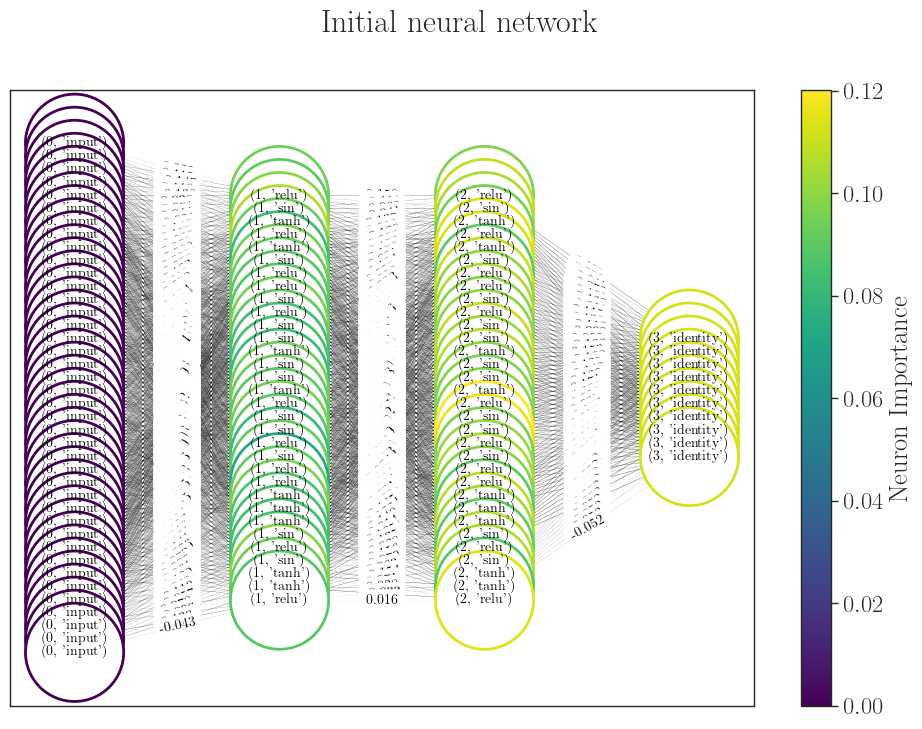

In [74]:
G, neuron_labels, neuron_importances = mlp.visualize_graph()
fig = mlp_plot(G, neuron_labels, neuron_importances)
plt.suptitle("Initial neural network")
plt.savefig(f"{fig_folder}/initial_graph.png")
plt.savefig(f"{fig_folder}/initial_graph.pdf")
plt.savefig(f"{fig_folder}/initial_graph.svg", format='svg', bbox_inches='tight')
wandb.log({"initial neural network": wandb.Image(plt, caption="initial neural network")})

In [75]:
initial_adjacency_matrix = mlp.adjacency_matrix()

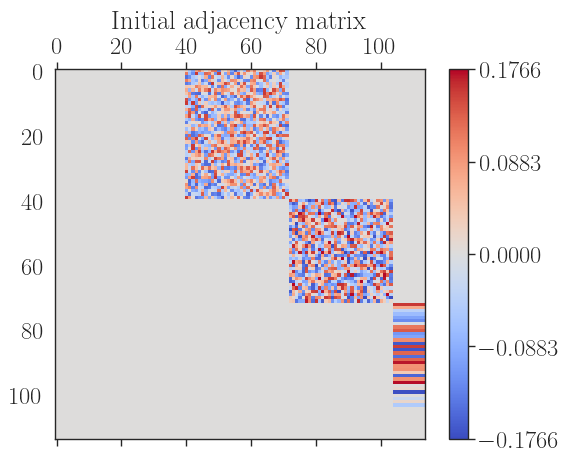

In [76]:
max_wt = np.max(np.abs(initial_adjacency_matrix))
norm = MidpointNormalize(vmin=-max_wt, vmax=max_wt, midpoint=0)
cmap = plt.get_cmap('coolwarm')

fig, ax = plt.subplots()
cax = ax.matshow(initial_adjacency_matrix, cmap=cmap, norm=norm)
cbar = fig.colorbar(cax, ticks=[-max_wt,
                                -max_wt/2, 
                                0,
                                max_wt/2,
                                max_wt])

# plt.colorbar()
plt.title("Initial adjacency matrix")
plt.savefig(f"{fig_folder}/initial_adjacency_matrix.png")
plt.savefig(f"{fig_folder}/initial_adjacency_matrix.pdf")
plt.savefig(f"{fig_folder}/initial_adjacency_matrix.svg", format='svg', bbox_inches='tight')
wandb.log({"initial adjacency matrix": wandb.Image(plt, caption="initial adjacency matrix")})

### initializing optimizer

In [77]:
opt = optimizer(learning_rate=learning_rate)
opt_state = initialize_optimizer_state(mlp, opt)

### training

In [78]:
train_loss_history = []
test_loss_history = []
accuracy_history = []
node_history = []
grad_norm_history = []
graph_history = []
update_history = []
time_history = []

test_loss = np.inf # initialize test loss to infinity
check_loss = np.inf # initialize check loss to infinity
check_accuracy = 0 # initialize check accuracy to 0

In [79]:
for epoch in range(num_epochs):

    start = time.time()
    train_loss, mlp, opt_state = train_step(mlp, x_train, y_train, opt_state, opt.update)
    _, grads  = compute_loss(mlp, x_train, y_train)
    grad_norm_val = grad_norm(grads)
    n_neurons = sum(mlp.get_shape())

    logging.info(f"Epoch {epoch :03d}, Loss: {train_loss.item()}, Neurons: {n_neurons}, Grad norm: {grad_norm_val :.3e}")
    wandb.log({"train_loss": train_loss.item(), "neurons": n_neurons, "grad_norm": grad_norm_val})
    train_loss_history.append((epoch, train_loss))
    grad_norm_history.append((epoch,grad_norm_val))
    node_history.append((epoch, n_neurons))
    key, add_key, sub_key, prob_key = jax.random.split(key,4)

    if ((epoch + 1) % intervene_every == 0
        or grad_norm_val < grad_norm_threshold) and epoch!=num_epochs-1: # intervene if gradient norm is below threshold, but not at last epoch
        test_loss, test_accuracy = test_step(mlp, x_test, y_test)
        logging.info(f"Epoch {epoch :03d}, Test loss: {test_loss.item()}, Test accuracy: {test_accuracy}")
        wandb.log({"test_loss": test_loss.item(), "test_accuracy": test_accuracy})
        test_loss_history.append((epoch,test_loss))
        accuracy_history.append((epoch, test_accuracy))
    
    stop = time.time()
    time_history.append((epoch, stop-start, n_neurons))



Epoch 000, Loss: 2.3025851249694824, Neurons: 74, Grad norm: 1.194e-01
Epoch 000, Loss: 2.3025851249694824, Neurons: 74, Grad norm: 1.194e-01
Epoch 001, Loss: 2.302168369293213, Neurons: 74, Grad norm: 1.213e-01
Epoch 001, Loss: 2.302168369293213, Neurons: 74, Grad norm: 1.213e-01
Epoch 002, Loss: 2.301711082458496, Neurons: 74, Grad norm: 1.235e-01
Epoch 002, Loss: 2.301711082458496, Neurons: 74, Grad norm: 1.235e-01
Epoch 003, Loss: 2.301206111907959, Neurons: 74, Grad norm: 1.260e-01
Epoch 003, Loss: 2.301206111907959, Neurons: 74, Grad norm: 1.260e-01
Epoch 004, Loss: 2.3006484508514404, Neurons: 74, Grad norm: 1.288e-01
Epoch 004, Loss: 2.3006484508514404, Neurons: 74, Grad norm: 1.288e-01
Epoch 005, Loss: 2.300032377243042, Neurons: 74, Grad norm: 1.318e-01
Epoch 005, Loss: 2.300032377243042, Neurons: 74, Grad norm: 1.318e-01
Epoch 006, Loss: 2.2993521690368652, Neurons: 74, Grad norm: 1.351e-01
Epoch 006, Loss: 2.2993521690368652, Neurons: 74, Grad norm: 1.351e-01
Epoch 007, Los

In [80]:
np.savetxt(f"{out_folder}/neurons.txt", node_history)
np.savetxt(f"{out_folder}/train_loss.txt", train_loss_history)
np.savetxt(f"{out_folder}/test_loss.txt", test_loss_history)
np.savetxt(f"{out_folder}/test_accuracy.txt", accuracy_history)
np.savetxt(f"{out_folder}/grad_norm.txt", grad_norm_history)

### evaluation

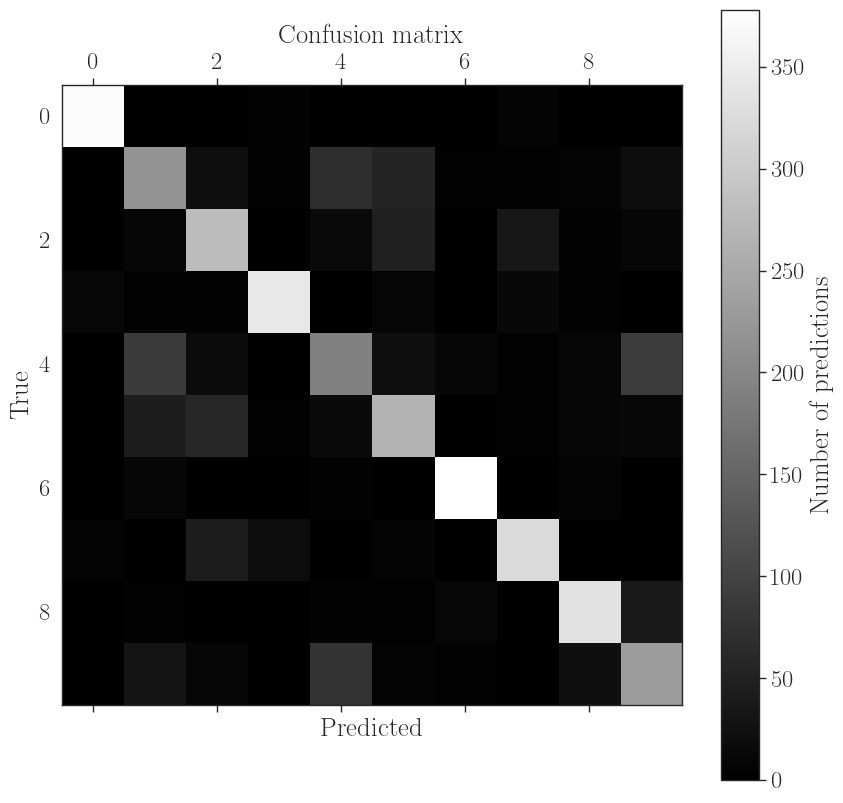

In [81]:
y_pred = jax.nn.softmax(jax.vmap(mlp)(x_test))
y_pred = np.argmax(y_pred, axis=-1)

confusion_matrix = np.zeros((10,10))
for true, pred in zip(y_test, y_pred):
    confusion_matrix[true, pred] += 1

np.savetxt(f"{out_folder}/confusion_matrix.txt", confusion_matrix)
fig, ax = plt.subplots(figsize=[10,10])
cax = ax.matshow(confusion_matrix, cmap='gray')
fig.colorbar(cax, label="Number of predictions")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix")
plt.savefig(f"{fig_folder}/confusion_matrix.png")
plt.savefig(f"{fig_folder}/confusion_matrix.pdf")
plt.savefig(f"{fig_folder}/confusion_matrix.svg", format='svg', bbox_inches='tight')
wandb.log({"confusion matrix": wandb.Image(plt, caption="confusion matrix")})


In [82]:
final_adjacency_matrix = mlp.adjacency_matrix()

In [83]:
np.savetxt(f"{out_folder}/final_adjacency_matrix.txt", final_adjacency_matrix)

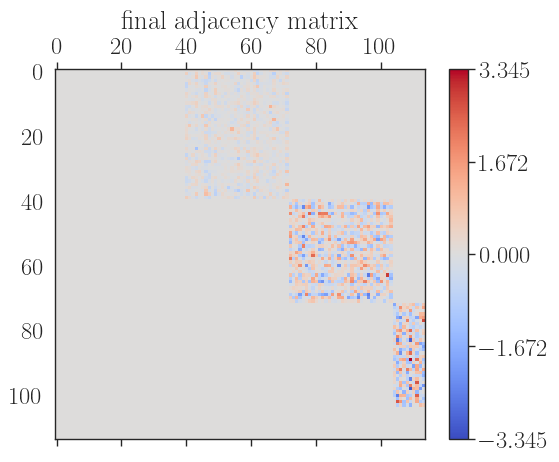

In [84]:
max_wt = np.max(np.abs(final_adjacency_matrix))
norm = MidpointNormalize(vmin=-max_wt, vmax=max_wt, midpoint=0)
cmap = plt.get_cmap('coolwarm')

fig, ax = plt.subplots()
cax = ax.matshow(final_adjacency_matrix, cmap=cmap, norm=norm)
cbar = fig.colorbar(cax, ticks=[-max_wt,
                                -max_wt/2, 
                                0,
                                max_wt/2,
                                max_wt])

# plt.colorbar()
plt.title("final adjacency matrix")
plt.savefig(f"{fig_folder}/final_adjacency_matrix.png")
plt.savefig(f"{fig_folder}/final_adjacency_matrix.pdf")
plt.savefig(f"{fig_folder}/final_adjacency_matrix.svg", format='svg', bbox_inches='tight')
wandb.log({"final adjacency matrix": wandb.Image(plt, caption="final adjacency matrix")})

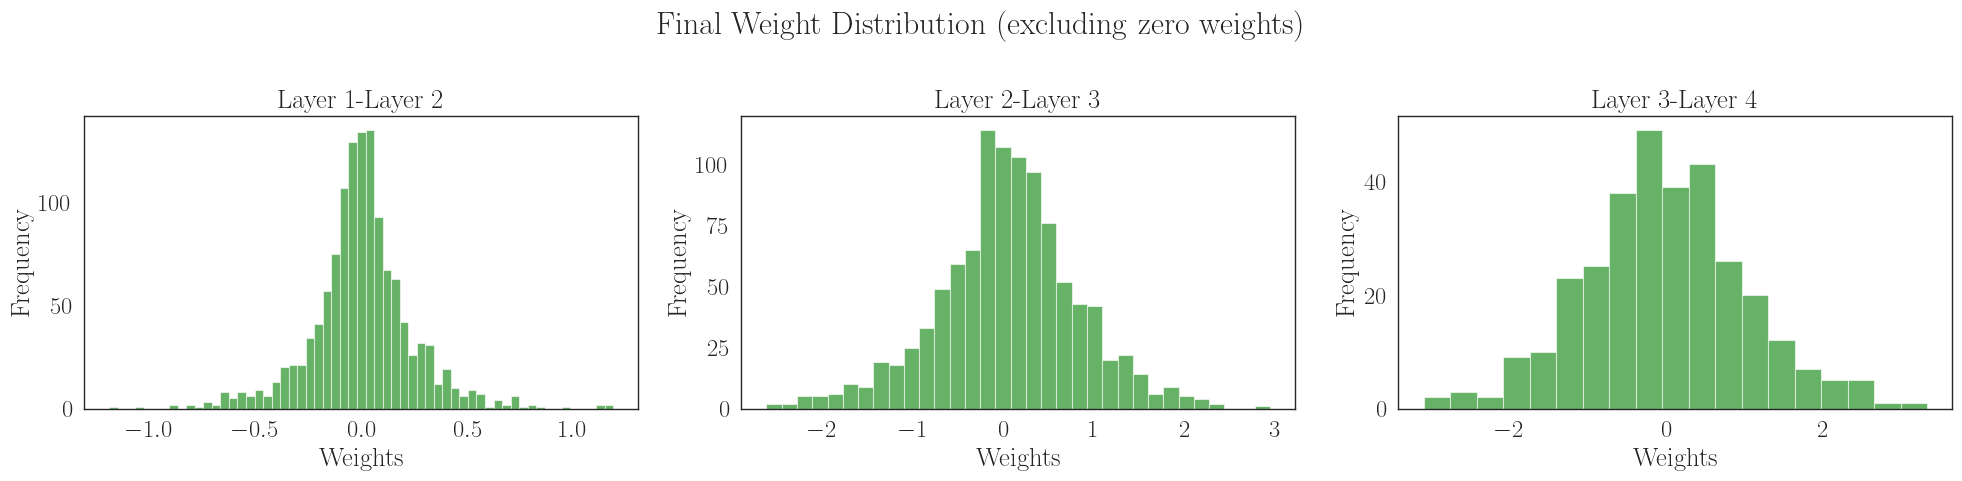

In [85]:
sub_matrices = np.split(final_adjacency_matrix, np.cumsum([mlp.input_size] + mlp.get_shape())[:-1])[:-1]

fig, axs = plt.subplots(1, len(sub_matrices), figsize=(20, 5))

for i, (sub_matrix, ax) in enumerate(zip(sub_matrices, axs), start=1):
    weights = sub_matrix.flatten()
    weights = weights[weights != 0]
    ax.hist(weights, bins="auto", density=False, alpha=0.6, color='g')
    ax.set_xlabel('Weights')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Layer {i}-Layer {i+1} ')


plt.suptitle('Final Weight Distribution (excluding zero weights)')
plt.tight_layout()
plt.savefig(f"{fig_folder}/final_weight_distribution.pdf")
plt.savefig(f"{fig_folder}/final_weight_distribution.png")
plt.savefig(f"{fig_folder}/final_weight_distribution.svg", format='svg', bbox_inches='tight')
plt.show()

In [86]:
train_epochs, train_loss = zip(*train_loss_history)
test_epochs, test_loss = zip(*test_loss_history)
grad_epochs, grad_norm_val = zip(*grad_norm_history)
node_epochs, n_neurons = zip(*node_history)
accuracy_epochs, test_accuracy = zip(*accuracy_history)

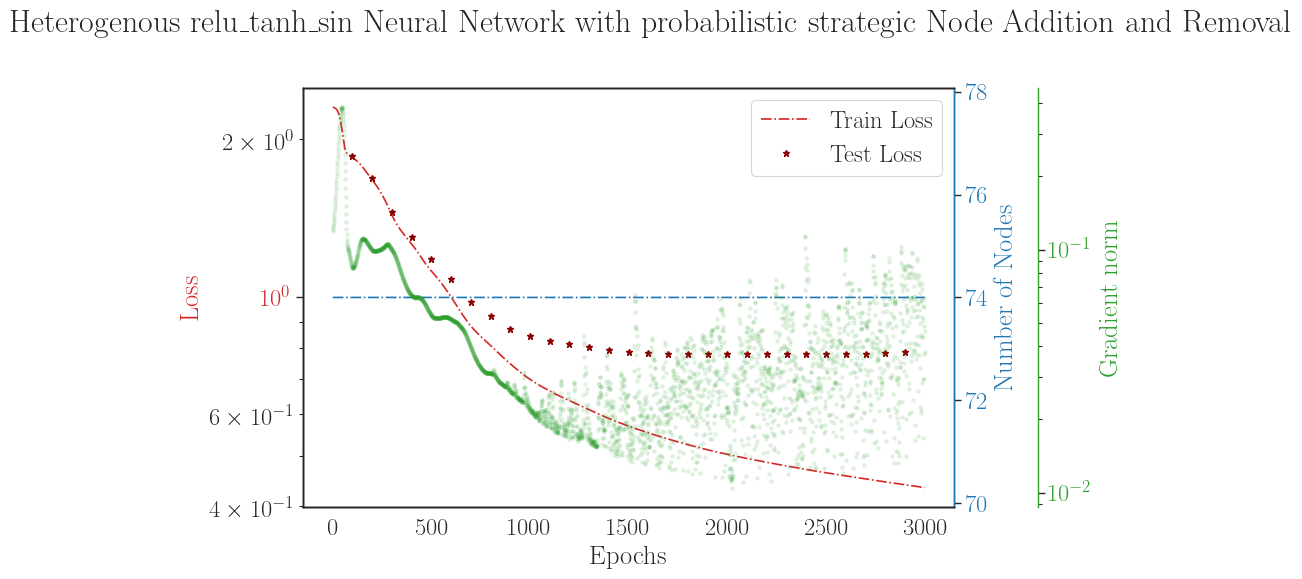

In [87]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(train_epochs, train_loss, "-.", color=color, label="Train Loss")
ax1.plot(test_epochs, test_loss, "*", color="darkred", label="Test Loss")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")
ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of Nodes', color=color)  # we already handled the x-label with ax1
ax2.plot(node_epochs, n_neurons, "-.", color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.spines['right'].set_color(color)


ax3 = ax1.twinx()

color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))  # Offset the third y-axis
ax3.plot(grad_epochs, grad_norm_val, '.', color=color, alpha = 0.1, label="Gradient Norm")
ax3.set_ylabel('Gradient norm', color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_yscale("log")
ax3.spines['right'].set_color(color)

# ax1.set_xscale("log")

plt.suptitle(f"Heterogenous {act_string} Neural Network with probabilistic strategic Node Addition and Removal")
fig.tight_layout()
plt.savefig(f"{fig_folder}/loss_curve.png")
plt.savefig(f"{fig_folder}/loss_curve.pdf")
plt.savefig(f"{fig_folder}/loss_curve.svg", format='svg', bbox_inches='tight')
wandb.log({"loss and nodes": wandb.Image(plt, caption="loss and nodes")})

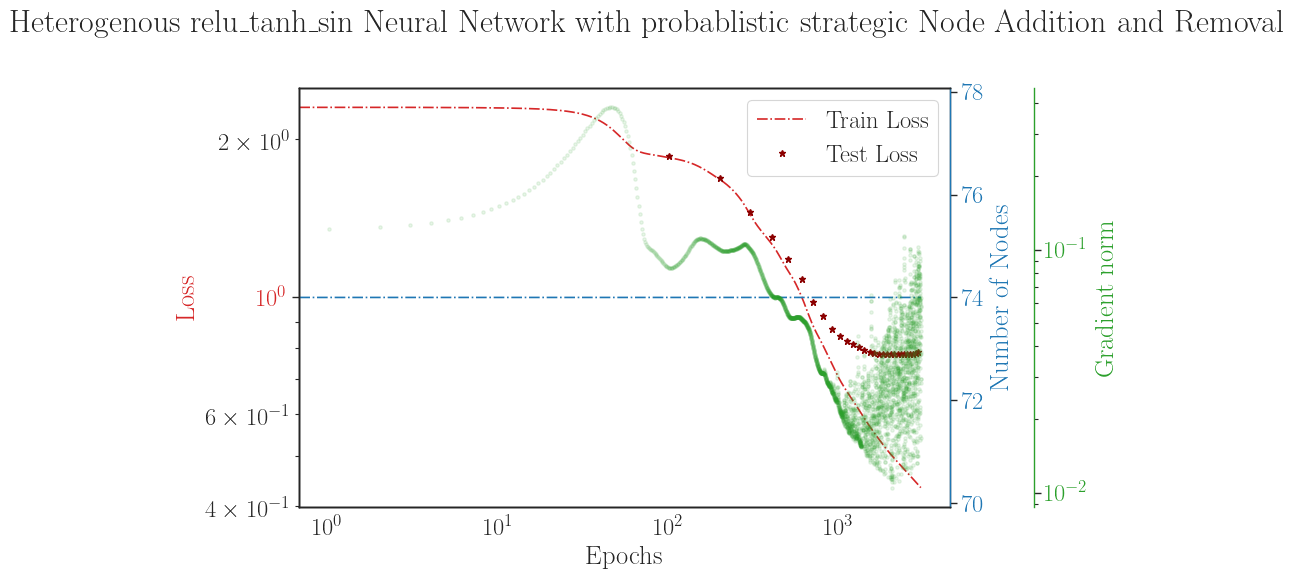

In [88]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(train_epochs, train_loss, "-.", color=color, label="Train Loss")
ax1.plot(test_epochs, test_loss, "*", color="darkred", label="Test Loss")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")
ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of Nodes', color=color)  # we already handled the x-label with ax1
ax2.plot(node_epochs, n_neurons, "-.", color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.spines['right'].set_color(color)


ax3 = ax1.twinx()

color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))  # Offset the third y-axis
ax3.plot(grad_epochs, grad_norm_val, '.', color=color, alpha = 0.1, label="Gradient Norm")
ax3.set_ylabel('Gradient norm', color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_yscale("log")
ax3.spines['right'].set_color(color)

ax1.set_xscale("log")

plt.suptitle(f"Heterogenous {act_string} Neural Network with probablistic strategic Node Addition and Removal")
fig.tight_layout()
plt.savefig(f"{fig_folder}/loss_curve_loglog.png")
plt.savefig(f"{fig_folder}/loss_curve_loglog.pdf")
plt.savefig(f"{fig_folder}/loss_curve_loglog.svg", format='svg', bbox_inches='tight')

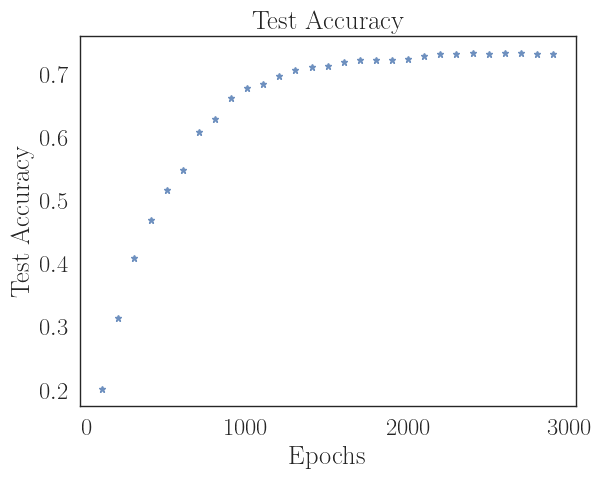

In [89]:
plt.plot(accuracy_epochs, test_accuracy, "*")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy")
plt.savefig(f"{fig_folder}/test_accuracy.png")
plt.savefig(f"{fig_folder}/test_accuracy.pdf")
plt.savefig(f"{fig_folder}/test_accuracy.svg", format='svg', bbox_inches='tight')

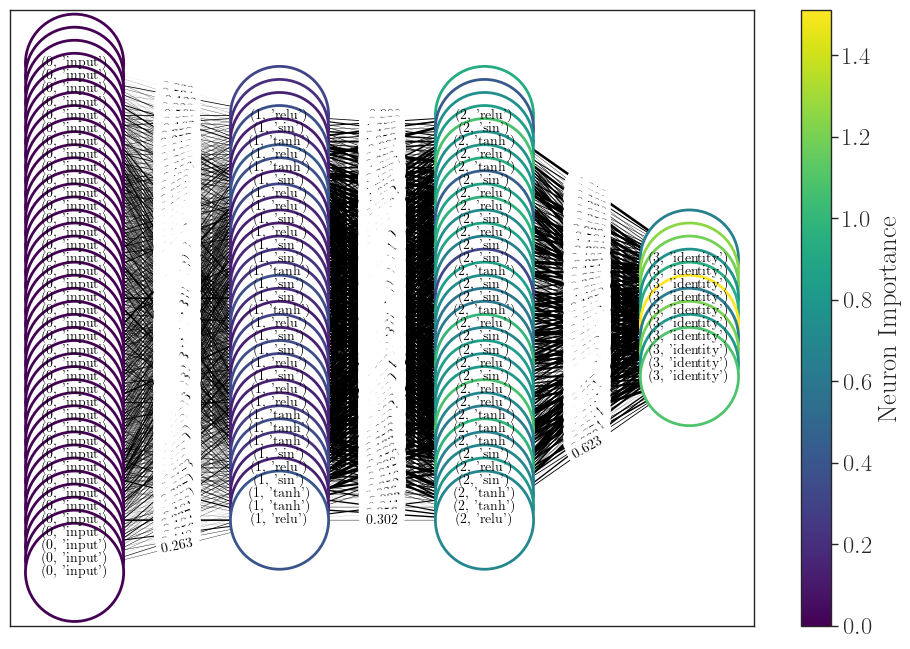

In [90]:
G, neuron_labels, neuron_importances = mlp.visualize_graph()
fig = mlp_plot(G, neuron_labels, neuron_importances)
plt.savefig(f"{fig_folder}/final_graph.png")
plt.savefig(f"{fig_folder}/final_graph.pdf")
plt.savefig(f"{fig_folder}/final_graph.svg", format='svg', bbox_inches='tight')
wandb.log({"final neural network": wandb.Image(plt, caption="final neural network")})

In [91]:
wandb.finish()

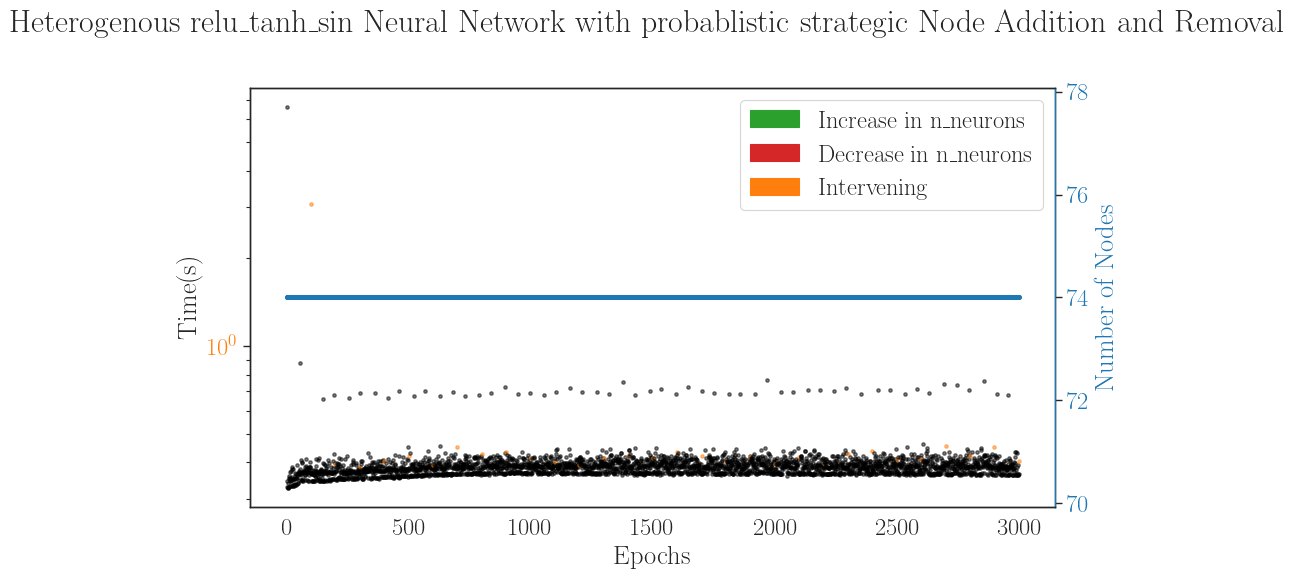

In [92]:
import matplotlib.patches as mpatches
colors = []
epochs, times, n_neurons = zip(*time_history)

diffs = np.diff(n_neurons, prepend=n_neurons[0])

colors = ['tab:green' if diff > 0 else
            'tab:red' if diff < 0 else
            'tab:orange' if (i+1)% intervene_every*int(n_neurons[i]/init_neurons) == 0 else
            'k' for i,diff in enumerate(diffs)]

fig, ax1 = plt.subplots(figsize=(10, 6))

# color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Time(s)')
for epoch, time, color in zip(epochs, times, colors):
    ax1.plot(epoch, time, ".", color=color, alpha=0.5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")

patches = [
    mpatches.Patch(color='tab:green', label='Increase in n_neurons'),
    mpatches.Patch(color='tab:red', label='Decrease in n_neurons'),
    mpatches.Patch(color='tab:orange', label='Intervening')
]

ax1.legend(handles=patches)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of Nodes', color=color)  # we already handled the x-label with ax1
ax2.plot(epochs, n_neurons, ".", color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.spines['right'].set_color(color)

plt.suptitle(f"Heterogenous {act_string} Neural Network with probablistic strategic Node Addition and Removal")
fig.tight_layout()
plt.savefig(f"{fig_folder}/time_curve.png")
plt.savefig(f"{fig_folder}/time_curve.pdf")
plt.savefig(f"{fig_folder}/time_curve.svg", format='svg', bbox_inches='tight')